# Clinical Trials by Volume of Publications

This notebook shows how use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to get a list of clinical trials records and then sort them by the total number of publications they cite.

## Load libraries and log in

In [1]:
# @markdown # Get the API library and login 
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly_express -U --quiet 
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm import tqdm_notebook as tqdm

#
# charts libs
import plotly_express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports 
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

DimCli v0.6.1.2 - Succesfully connected to <https://app.dimensions.ai> (method: manual login)


## Query for Clinical Trials

In [2]:
q = """search clinical_trials where category_rcdc.name="Multiple Sclerosis" 
        and active_years=[2017, 2018, 2019] 
        return clinical_trials[basics+publication_ids]"""

In [13]:
df = dsl.query_iterative(q).as_dataframe()
df.head()

1000 / 2132
2000 / 2132
2132 / 2132


active_years           id  \
0                     [2005, 2006, 2007, 2008, 2009]  NCT00257855   
1                           [2003, 2004, 2005, 2006]  NCT00260741   
2               [2006, 2007, 2008, 2009, 2010, 2011]  NCT00261326   
3  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...  NCT00262314   
4                                               None  NCT00267319   

    publication_ids                               investigator_details  \
0  [pub.1016078006]  [[Raju Kapoor, MD PhD, Study Director, Nationa...   
1              None  [[Mark Agius, MD, Principal Investigator, Univ...   
2  [pub.1014996254]  [[Jette L Frederiksen, DrMed, Study Director, ...   
3              None  [[Randy Bennett, , Study Director, EMD Serono,...   
4              None  [[Zuzana Priborska, , Study Director, Sanofi, ...   

                                               title  
0  A Randomised Controlled Trial of Neuroprotecti...  
1  Cannabis for Spasticity in Multiple Sclerosis:...  
2  Simvastatin Treatment of Patients With Acut Op...  
3  Prospective, Open-label Tolerability and Safet...  
4  Fatigue Outcomes of Copaxone Users in Relapsin...

## Counting publications per clinical trial

Before we can count publications, we should ensure that all the values are 'countable'. So we have to transform all None values in `publication_ids` into empty lists first.

In [15]:
# replace empty values with empty lists so that they can be counted
for row in df.loc[df.publication_ids.isnull(), 'publication_ids'].index:
    df.at[row, 'publication_ids'] = []

Now it's ok to count publications

In [16]:
# create new column
df['pubs_tot'] = df['publication_ids'].apply(lambda x: len(x))
# sort 
df.sort_values("pubs_tot", ascending=False, inplace=True)
df.head(5)

active_years           id  \
1695              [2019, 2020, 2021]  NCT04073940   
1622  [2018, 2019, 2020, 2021, 2022]  NCT03782246   
383   [2014, 2015, 2016, 2017, 2018]  NCT02104661   
625   [2016, 2017, 2018, 2019, 2020]  NCT03004079   
309                     [2014, 2015]  NCT02367222   

                                        publication_ids  \
1695  [pub.1022342218, pub.1010367173, pub.104532283...   
1622  [pub.1028617232, pub.1035385239, pub.103188188...   
383   [pub.1042342392, pub.1016078006, pub.102366073...   
625   [pub.1033284389, pub.1053353274, pub.107152083...   
309   [pub.1026901855, pub.1051111163, pub.106264497...   

                                   investigator_details  \
1695                                               None   
1622  [[Dawn Ehde, PhD, Principal Investigator, Univ...   
383   [[Gavin Givannoni, , Principal Investigator, Q...   
625   [[Myla Goldman, MD, Principal Investigator, Un...   
309   [[Salah Mahmud, MD, PhD, Principal Investigato...   

                                                  title  pubs_tot  
1695  Exploration of Brain Changes Due to a Targeted...        92  
1622  Mindfulness-based Cognitive Therapy and Cognit...        72  
383   OxCarbazepine as a Neuroprotective Agent in MS...        48  
625   Assessment of the Clinical Importance of Insul...        46  
309   An Observational Retrospective Database Analys...        43

A simple data visualization

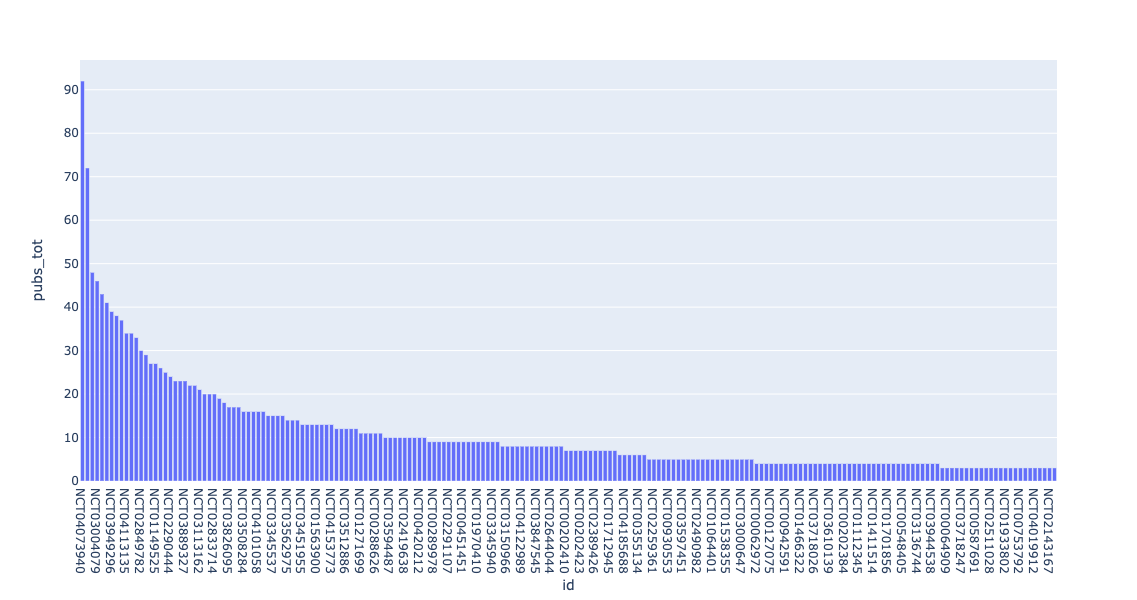

In [24]:
px.bar(df[:200], x="id", y="pubs_tot", 
      hover_name="title", hover_data=["active_years"])